In [83]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import brevitas
import brevitas.nn as qnn

from concrete.ml.torch.compile import compile_brevitas_qat_model

print(f"torch = {torch.__version__}")
print(f"brevitas = {brevitas.__version__}")
print(f"concrete-ml = {concrete.ml.__version__}")


torch = 2.0.1+cu117
brevitas = 0.8.0
concrete-ml = 1.1.0


## MNIST Dataset

In [7]:
def manage_dataset(train_kwargs, test_kwargs):
    """Get training and test parts of MNIST data-set."""

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.Lambda(torch.flatten),
        ]
    )

    # Manage data-sets
    dataset1 = datasets.MNIST("./data", train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST("./data", train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    return train_loader, test_loader

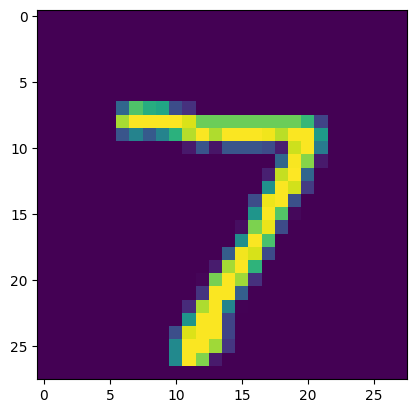

In [13]:
train_loader, test_loader = manage_dataset({"batch_size": 32}, 
                                           {"batch_size": 32})
img = test_loader.dataset.data[0]
plt.imshow(img)

In [14]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )

In [23]:
img_size = train_loader.dataset.data[0].shape[0]

## Model

In [34]:
# parameters
sparsity = 4  # smaller value => less active neurons
quantization_bits = 6  # faster = more accurate

In [76]:
from model import MNISTQATModel

device = torch.device("cpu")
model = MNISTQATModel(quantization_bits, quantization_bits)
model = model.to(device)

 Load pre-trained model for post-training quantization

In [77]:
checkpoint = torch.load("state_dict.pt", map_location=device)
print(f"keys = {checkpoint.keys()}")
checkpoint

keys = odict_keys(['fc1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'fc2.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'fc3.weight', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'fc4.weight'])


OrderedDict([('fc1.weight',
              tensor([[0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., 0.0000e+00, -0.0000e+00,
                       3.6892e-41],
                      [-0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
                       0.0000e+00],
                      [2.7555e-41, 0.0000e+00, -0.0000e+00,  ..., -0.0000e+00, -0.0000e+00,
                       0.0000e+00],
                      ...,
                      [-0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
                       0.0000e+00],
                      [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., -0.0000e+00, 0.0000e+00,
                       -0.0000e+00],
                      [-0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., -0.0000e+00, 0.0000e+00,
                       0.0000e+00]])),
             ('bn1.weight',
              tensor([0.7123, 0.7720, 0.9259, 0.9730, 1.0520, 1.3993, 0.5174, 1.0830, 1.5790,
                      1.6062, 0.7404, 1.4128, 1.1031, 1.2

In [78]:
model.load_state_dict(checkpoint)
model

MNISTQATModel(
  (quant_inp): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ConstScaling(
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (value): StatelessBuffer()
          )
          (int_scaling_impl): IntScaling()
          (zero_point_impl): ZeroZeroPoint(
            (zero_point): StatelessBuffe

In [79]:
model.fc1.int_weight().unique()

tensor([-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18,
        -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
         -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31], dtype=torch.int8)

## Prepare the numpy test dataset

In [28]:
# Prepare tests
test_data = np.zeros((len(test_loader.dataset), img_size * img_size))
test_target = np.zeros((len(test_loader.dataset), 1))
idx = 0

for data, target in tqdm(test_loader):
    target_np = target.cpu().numpy()
    for idx_batch, im in enumerate(data.numpy()):
        test_data[idx] = im
        test_target[idx] = target_np[idx_batch]
        idx += 1

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:01<00:00, 197.35it/s]


In [31]:
print(f"{test_data.shape = }")
print(f"{type(test_data) = }")

test_data.shape = (10000, 784)
type(test_data) = <class 'numpy.ndarray'>


## Inference in FHE

In [82]:
accuracy = {}
current_index = 3
test_data_length_reduced = 2  # This is notably the length of the computation in FHE
test_data_length_full = 10000

In [87]:
from typing import Union, Any
def convert_torch_tensor_or_numpy_array_to_numpy_array(
    torch_tensor_or_numpy_array: Union[torch.Tensor, np.ndarray],
) -> np.ndarray:
    """Convert a torch tensor or a numpy array to a numpy array.
    source: src/concrete/ml/torch/compile.py
    
    Args:
        torch_tensor_or_numpy_array (Tensor): the value that is either
            a torch tensor or a numpy array.

    Returns:
        numpy.ndarray: the value converted to a numpy array.
    """
    return (
        torch_tensor_or_numpy_array
        if isinstance(torch_tensor_or_numpy_array, np.ndarray)
        else torch_tensor_or_numpy_array.cpu().numpy()
    )

def to_tuple(x: Any) -> tuple:
    """Make the input a tuple if it is not already the case.

    Args:
        x (Any): The input to consider. It can already be an input.

    Returns:
        tuple: The input as a tuple.
    """
    # If the input is not a tuple, return a tuple of a single element
    if not isinstance(x, tuple):
        return (x,)

    return x

In [88]:
inputset_as_numpy_tuple = tuple(
    convert_torch_tensor_or_numpy_array_to_numpy_array(val) for val in to_tuple(test_data)
)

In [89]:
inputset_as_numpy_tuple

(array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
         -0.42421296, -0.42421296],
        [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
         -0.42421296, -0.42421296],
        [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
         -0.42421296, -0.42421296],
        ...,
        [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
         -0.42421296, -0.42421296],
        [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
         -0.42421296, -0.42421296],
        [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
         -0.42421296, -0.42421296]]),)

Process where data is processed in `compile_and_test`

```
compile_and_test -> compile_brevitas_qat_model -> compile_onnx_model -> _compile_torch_or_onnx_model -> build_quantized_module -> 
```
